In [1]:
# %load defaults.ipy
import numpy as np
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 600
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('../python')
from plot_info import showAndSave, savePlot, get_environment
import plot_info
plot_info.set_notebook_name("WassersteinDistancesPerturbationsAll.ipynb")

import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import os
import h5py
import ot
import sys
import scipy
import scipy.stats

# we had some issues on the euler cluster loading the correct libraries
for p in sys.path:
    if 'matplotlib' in p.lower():
        sys.path.remove(p)
    if 'netcdf' in p.lower():
        sys.path.remove(p)

from mpl_toolkits.mplot3d import Axes3D

def load(f, sample):
    if '.nc' in f:
        with netCDF4.Dataset(f) as d:
            return d.variables['sample_%d_rho' % sample][:,:,0]
    else:
        f = os.path.join(f, 'kh_%d/kh_1.h5' % sample)
        with h5py.File(f) as d:
            return d['rho'][:,:,0]
        

print("STATISTICAL_KH_PERTS={}".format(plot_info.get_environment("STATISTICAL_KH_PERTS", [])))
print("STATISTICAL_KH_PERTS_NORMAL_UNIFORM={}".format(plot_info.get_environment("STATISTICAL_KH_PERTS_NORMAL_UNIFORM", [])))



STATISTICAL_KH_PERTS=/cluster/project/sam/klye/systemspaperdata/
STATISTICAL_KH_PERTS_NORMAL_UNIFORM=/cluster/project/sam/klye/systemspaperdata/perturbation/


# Histogram plotting

In [2]:
def plot_histograms2(N, M, perturbation,  name, minValue, maxValue, x, y, xp, yp, valuesx, valuesy):
    
    
    
   
    
    plt.hist2d(valuesx, valuesy, bins=20, normed=True, range=[[minValue, maxValue], [minValue, maxValue]])
    plt.colorbar()
    plt.xlabel('Value of $\\rho(%.2f,%.2f)$' % (x,y))
    plt.ylabel('Value of $\\rho(%.2f,%.2f)$' % (xp,yp))
    plt.title('Histogram at resolution %d, $\\epsilon = %.4f$, for %s,\nbetween $(%.2f, %.2f)$ and $(%.2f, %.2f)$' %  (N, perturbation, name, x,y,xp,yp))
    
    showAndSave('hist2pt_perturbation_%s_%.5f_%d_%.1f_%.1f_%.1f_%.1f' %(name, perturbation, N, x, y, xp, yp))
    
    H, xedges, yedges = np.histogram2d(valuesx, valuesy, bins=20, normed=True,range=[[minValue, maxValue], [minValue, maxValue]])
   
    fig = plt.figure(figsize=(10,8))
    ax = fig.gca(projection='3d')
    Xvalues, Yvalues = np.meshgrid(xedges[:-1], yedges[:-1])
    surf = ax.plot_surface(Xvalues, Yvalues, H)
    plt.xlabel('Value of $\\rho(%.2f,%.2f)$' % (x,y))
    plt.ylabel('Value of $\\rho(%.2f,%.2f)$' % (xp,yp))
    plt.title('Histogram at resolution %d, , $\\epsilon = %.4f$, for %s,\nbetween $(%.2f, %.2f)$ and $(%.2f, %.2f)$' % (N, perturbation, name, x,y,xp,yp))
    ax.dist = 12
    ax.set_xticks(np.array(ax.get_xticks())[::4])
    ax.set_yticks(np.array(ax.get_yticks())[::4])
    ax.set_zticks(np.array(ax.get_zticks())[::2])
    ax.yaxis.labelpad=10
    ax.xaxis.labelpad=10
    ax.zaxis.labelpad=10
    showAndSave('hist2pt_perturbation_surface_%s_%.5f_%d_%.1f_%.1f_%.1f_%.1f' %(name, perturbation, N, x, y, xp, yp))

In [3]:
def plotHistograms(name, resolution, perturbations, basename, samples):
   
    points = [0.2, 0.4, 0.7, 0.8]
    min_values = {}
    max_values = {}
    
    
    for x in points:
        min_values[x] = {}
        max_values[x] = {}
        for y in points:
            min_values[x][y] = {}
            max_values[x][y] = {}
            for xp in points:
                min_values[x][y][xp] = {}
                max_values[x][y][xp] = {}
                for yp in points:
                    min_values[x][y][xp][yp] = 100000000
                    max_values[x][y][xp][yp] = -100000000
                    
    
    for p in perturbations:
        # first we load the data
        data = np.zeros((resolution, resolution, samples))
        filename = basename.format(perturbation=p)
        for k in range(samples):
            data[:,:,k] = load(filename, k)
            
    
        for x in points:
            for y in points:
                for xp in points:
                    for yp in points:
                        i = int(x*resolution)
                        j = int(y*resolution)
                        ip = int(xp*resolution)
                        jp = int(yp*resolution)
                        min_values[x][y][xp][yp] = min(np.amin([data[i,j,:], data[ip,jp,:]]), min_values[x][y][xp][yp])
                        
                        
                        max_values[x][y][xp][yp] = max(np.amax([data[i,j,:], data[ip,jp,:]]), max_values[x][y][xp][yp])
                        
                        # First we find minimum and maximum over all resolutions and all samples
                        # we need this to equalize the histograms properly.
                    
                

                    
    for p in perturbations:
        filename = basename.format(perturbation=p)
        data = np.zeros((resolution, resolution, samples))
        for k in range(samples):
            data[:,:,k] = load(filename, k)
            
        for x in points:
            for y in points:
                for xp in points:
                    for yp in points:
                        # Limit plotting
                        if x == 0.7 and y == 0.7:
                            if xp == 0.7:
                                if yp != 0.8:
                                    continue
                            elif xp == 0.4:
                                if yp != 0.2:
                                    continue
                            else:
                                continue
                        else:
                            continue
                            
                        valuesx = []
                        valuesy = []
                        
                        i = int(x*resolution)
                        j = int(y*resolution)
                        ip = int(xp*resolution)
                        jp = int(yp*resolution)
                        
                        for k in range(samples):
                            
                            valuesx.append(data[i, j,k])
                            valuesy.append(data[ip, jp,k])
                
                        plot_histograms2(resolution, samples, p, name, min_values[x][y][xp][yp], max_values[x][y][xp][yp], x,y, xp, yp, valuesx, valuesy)

        

# Computing Wasserstein distances

In [4]:
def wasserstein_point2_fast(data1, data2, i, j, ip, jp, a, b, xs, xt):
    """
    Computes the Wasserstein distance for a single point in the spatain domain
    """
    

    xs[:,0] = data1[i,j,:]
    xs[:,1] = data1[ip, jp, :]

    xt[:,0] = data2[i,j, :]
    xt[:,1] = data2[ip, jp, :]


    M = ot.dist(xs, xt, metric='euclidean')
    G0 = ot.emd(a,b,M)

    return np.sum(G0*M)

def wasserstein2pt_fast(data1, data2):
    """
    Approximate the L^1(W_1) distance (||W_1(nu1, nu2)||_{L^1})
    """
    M = data1.shape[2]
    a = np.ones(M)/M
    b = np.ones(M)/M
    xs = np.zeros((M,2))
    xt = np.zeros((M,2))
    N = data1.shape[0]
    distance = 0
    

    points = 0.1*np.array(range(0,10))
    for (n,x) in enumerate(points):
        for y in points:

            for xp in points:
                for yp in points:
                    i = int(x*N)
                    j = int(y*N)
                    ip = int(xp*N)
                    jp = int(yp*N)
                    distance += wasserstein_point2_fast(data1, data2, i,j, ip, jp, a, b, xs, xt)


    
    return distance / len(points)**4

def wasserstein1pt_fast(data1, data2):
    """
    Approximate the L^1(W_1) distance (||W_1(nu1, nu2)||_{L^1})
    """
    N = data1.shape[0]
    distance = 0
    
    for i in range(N):
        for j in range(N):
            distance += scipy.stats.wasserstein_distance(data1[i,j,:], data2[i,j,:])


    
    return distance / N**2


def plotWassersteinConvergence(name, basename, r, perturbations):
    wasserstein2pterrors = []
    for (n, p) in enumerate(perturbations[:-1]):
        filename = basename.format(perturbation=p)
        filename_coarse = basename.format(perturbation=perturbations[-1])
        data1 = np.zeros((r,r,r))
        data2 = np.zeros((r,r,r))
        for k in range(r):
            d1 = load(filename, k)
            d2 = load(filename_coarse, k)
            data1[:,:,k] = d1
            data2[:,:,k] = d2

        wasserstein2pterrors.append(wasserstein2pt_fast(data1, data2))
        print("wasserstein2pterrors=%s" % wasserstein2pterrors)
    

    plt.loglog(perturbations[1:], wasserstein2pterrors, '-o', basex=2, basey=2)
    plt.xlabel("Perturbation $\\epsilon$")
    plt.ylabel('$||W_1(\\nu^{2, \\Delta x, \\epsilon}, \\nu^{2,\\Delta x, \\epsilon_0})||_{L^1(D\\times D)}$')
    plt.title("Wasserstein convergence for %s\nfor second correlation measure,\nwith respect to perturbation size\nagainst a reference solution with $\epsilon_0=%.4f$"%(name,perturbations[-1]))
    showAndSave('%s_wasserstein_perturbation_convergence_2pt_all' % name)
    
    
    
    # one point
    wasserstein1pterrors = []
    for (n, p) in enumerate(perturbations[:-1]):
        filename = basename.format(perturbation=p)
        filename_coarse = basename.format(perturbation=perturbations[-1])
        data1 = np.zeros((r,r,r))
        data2 = np.zeros((r,r,r))
        for k in range(r):
            d1 = load(filename, k)
            d2 = load(filename_coarse, k)
            data1[:,:,k] = d1
            data2[:,:,k] = d2

        wasserstein1pterrors.append(wasserstein1pt_fast(data1, data2))
        print("wasserstein1pterrors=%s" % wasserstein1pterrors)
    

    plt.loglog(perturbations[1:], wasserstein1pterrors, '-o', basex=2, basey=2)
    plt.xlabel("Perturbation $\\epsilon$")
    plt.ylabel('$||W_1(\\nu^{1, \\Delta x, \\epsilon}, \\nu^{1,\\Delta x, \\epsilon_0})||_{L^1(D)}$')
    plt.title("Wasserstein convergence for %s\nfor first correlation measure,\nwith respect to perturbation size\nagainst a reference solution with $\epsilon_0=%.4f$"%(name,perturbations[-1]))
    showAndSave('%s_wasserstein_perturbation_convergence_1pt_all' % name)
    
    

def plotWassersteinConvergenceDifferentTypes(name, filenames, r, perturbations_inverse):
    wasserstein2pterrors = []
    types = [k for k in filenames.keys()]
    
    if len(types)!=2:
        raise Exception("Only support two perturbation types")
    for filename_a, filename_b in zip(filenames[types[0]], filenames[types[1]]):
        
        data1 = np.zeros((r,r,r))
        data2 = np.zeros((r,r,r))
        for k in range(r):
            d1 = load(filename_a, k)
            d2 = load(filename_b, k)
            data1[:,:,k] = d1
            data2[:,:,k] = d2

        wasserstein2pterrors.append(wasserstein2pt_fast(data1, data2))
        print("wasserstein2pterrors=%s" % wasserstein2pterrors)
    

    plt.loglog(1.0/np.array(perturbations_inverse,dtype=np.float64), wasserstein2pterrors, '-o', basex=2, basey=2)
    plt.xlabel("Perturbation $\\epsilon$")
    
    plt.ylabel('$||W_1(\\nu^{2, \\Delta x, \\epsilon}_{\\mathrm{%s}}, \\nu^{2,\\Delta x, \\epsilon}_{\\mathrm{%s}})||_{L^1(D\\times D)}$' % (types[0], types[1]))
    plt.title("Wasserstein convergence for %s\nfor second correlation measure"%(name))
    showAndSave('%s_type_comparison_wasserstein_perturbation_convergence_2pt_all' % name)
    
    
    
    
    # one point
    wasserstein1pterrors = []
   
   
    for filename_a, filename_b in zip(filenames[types[0]], filenames[types[1]]):
        
        data1 = np.zeros((r,r,r))
        data2 = np.zeros((r,r,r))
        for k in range(r):
            d1 = load(filename_a, k)
            d2 = load(filename_b, k)
            data1[:,:,k] = d1
            data2[:,:,k] = d2

        wasserstein1pterrors.append(wasserstein1pt_fast(data1, data2))
        print("wasserstein1pterrors=%s" % wasserstein1pterrors)
    

    plt.loglog(1.0/np.array(perturbations_inverse,dtype=np.float64), wasserstein1pterrors, '-o', basex=2, basey=2)
    plt.xlabel("Perturbation $\\epsilon$")
    
    plt.ylabel('$||W_1(\\nu^{1, \\Delta x, \\epsilon}_{\\mathrm{%s}}, \\nu^{1,\\Delta x, \\epsilon}_{\\mathrm{%s}})||_{L^1(D)}$' % (types[0], types[1]))
    plt.title("Wasserstein convergence for %s\nfor first correlation measure,\nwith respect to perturbation size"%(name))
    showAndSave('%s_type_comparison_wasserstein_perturbation_convergence_1pt_all' % name)

# Kelvin-Helmholtz

## Convergence as we refine the perturbation

In the cell below, we look at the convergence

$$\mathrm{Error}(\epsilon)=\|W_1(\mu^{\epsilon}, \mu^{\epsilon_{\mathrm{ref}}})\|_{L^1}$$

where $\mu^{\epsilon_{\mathrm{ref}}}$ is a reference solution with small perturbation size ($\epsilon_{\mathrm{ref}}=0.0025$). We keep the number of samples and resolution fixed ($1024$ samples at $1024x1024$ resolution).

wasserstein2pterrors=[0.15148356012280353]
wasserstein2pterrors=[0.15148356012280353, 0.14306742462585548]
wasserstein2pterrors=[0.15148356012280353, 0.14306742462585548, 0.13206227535976744]
wasserstein2pterrors=[0.15148356012280353, 0.14306742462585548, 0.13206227535976744, 0.12260489170875462]
wasserstein2pterrors=[0.15148356012280353, 0.14306742462585548, 0.13206227535976744, 0.12260489170875462, 0.09067045292653121]
wasserstein2pterrors=[0.15148356012280353, 0.14306742462585548, 0.13206227535976744, 0.12260489170875462, 0.09067045292653121, 0.04992071940620877]
wasserstein2pterrors=[0.15148356012280353, 0.14306742462585548, 0.13206227535976744, 0.12260489170875462, 0.09067045292653121, 0.04992071940620877, 0.037863532820347746]
wasserstein2pterrors=[0.15148356012280353, 0.14306742462585548, 0.13206227535976744, 0.12260489170875462, 0.09067045292653121, 0.04992071940620877, 0.037863532820347746, 0.026363890433134526]


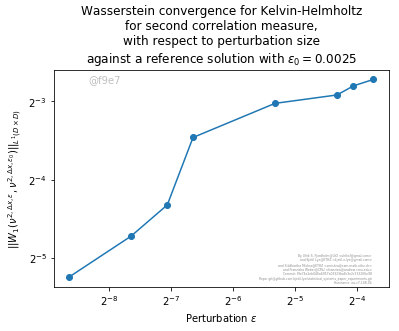

wasserstein1pterrors=[0.0891852984063091]
wasserstein1pterrors=[0.0891852984063091, 0.08399768922945898]
wasserstein1pterrors=[0.0891852984063091, 0.08399768922945898, 0.07747861734239085]
wasserstein1pterrors=[0.0891852984063091, 0.08399768922945898, 0.07747861734239085, 0.07181895786022692]
wasserstein1pterrors=[0.0891852984063091, 0.08399768922945898, 0.07747861734239085, 0.07181895786022692, 0.05168733094164745]
wasserstein1pterrors=[0.0891852984063091, 0.08399768922945898, 0.07747861734239085, 0.07181895786022692, 0.05168733094164745, 0.026625717049931275]
wasserstein1pterrors=[0.0891852984063091, 0.08399768922945898, 0.07747861734239085, 0.07181895786022692, 0.05168733094164745, 0.026625717049931275, 0.020150588577038123]
wasserstein1pterrors=[0.0891852984063091, 0.08399768922945898, 0.07747861734239085, 0.07181895786022692, 0.05168733094164745, 0.026625717049931275, 0.020150588577038123, 0.012604816871029184]


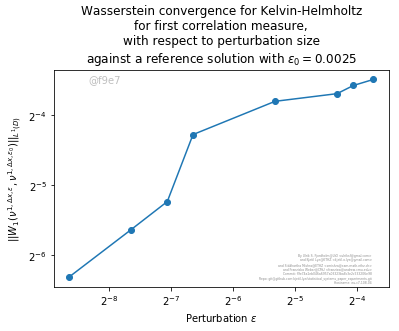

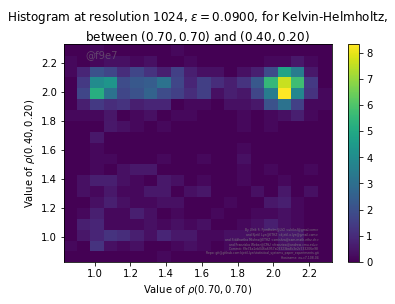

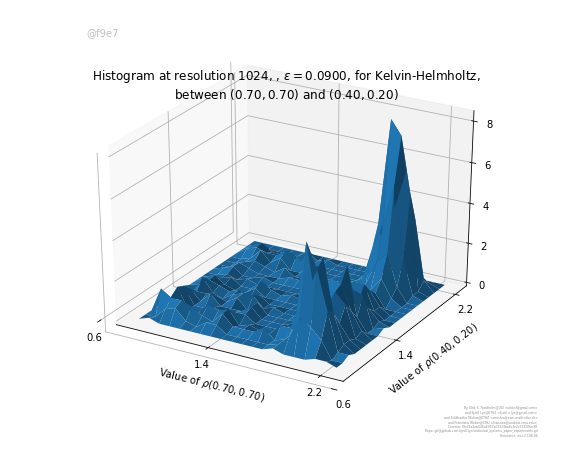

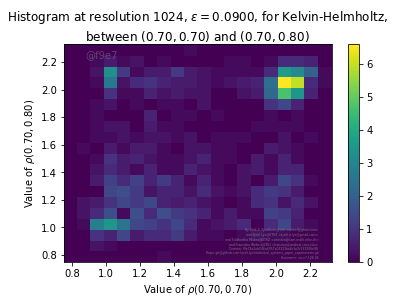

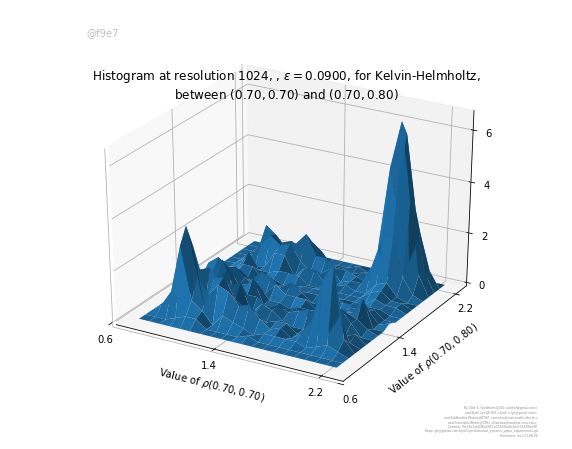

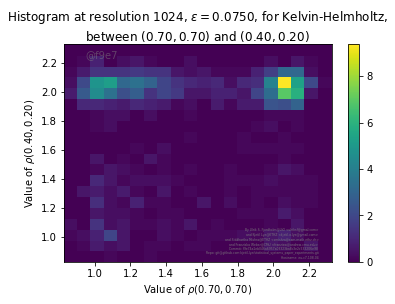

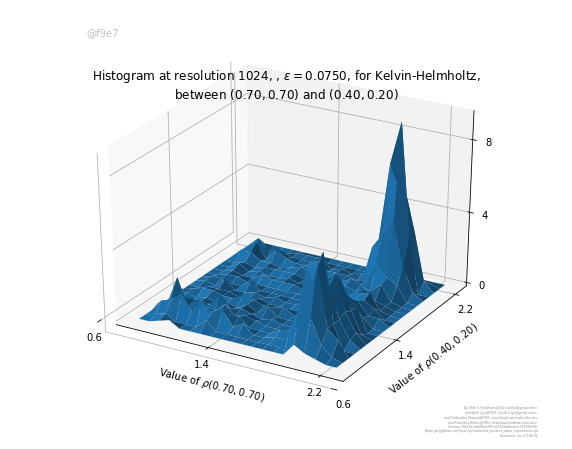

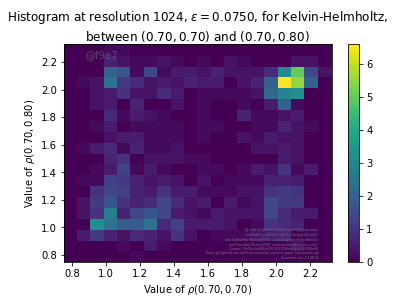

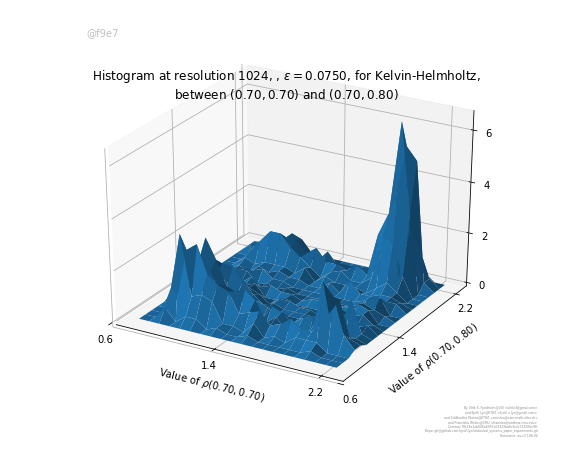

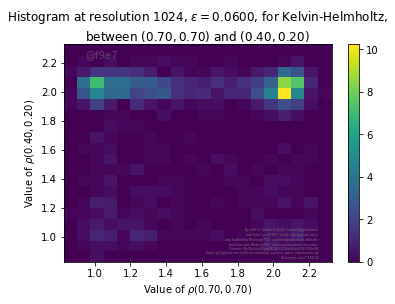

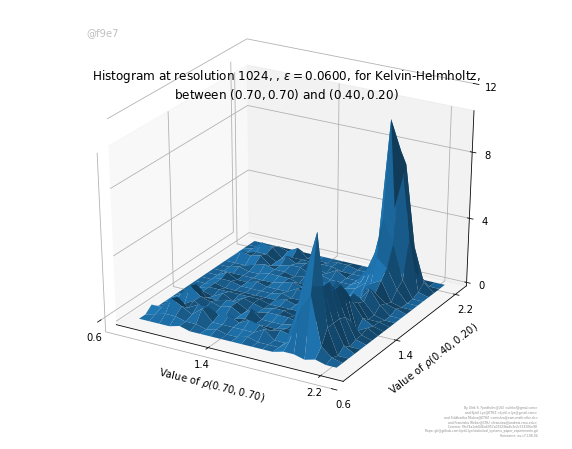

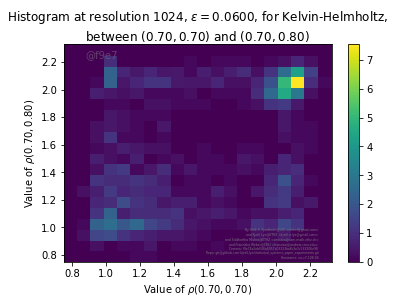

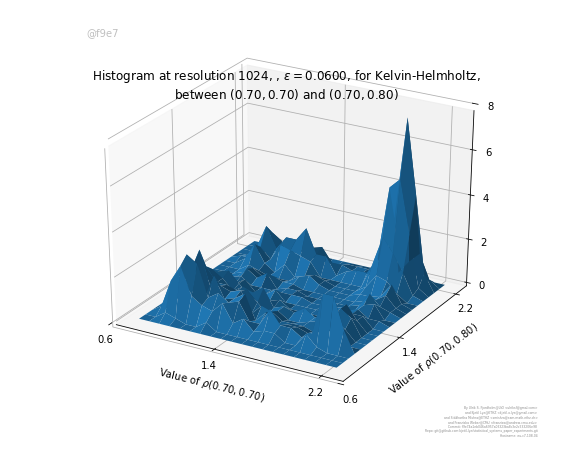

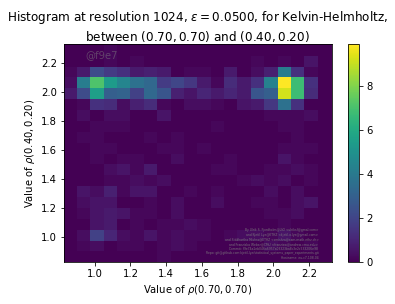

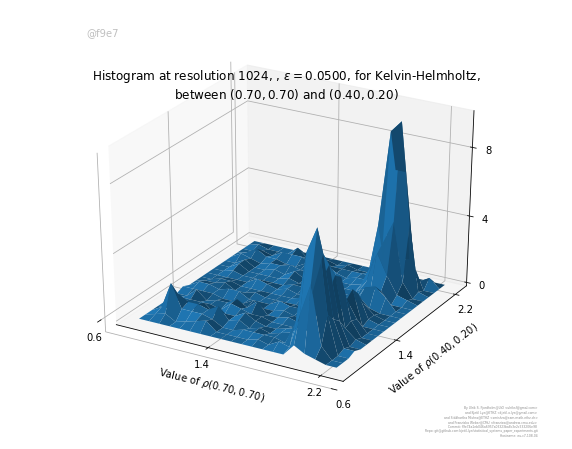

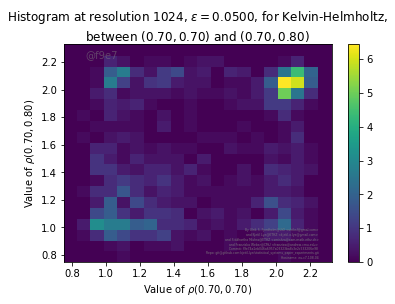

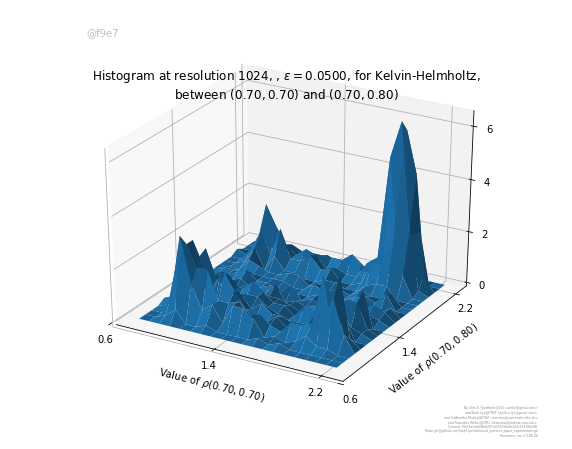

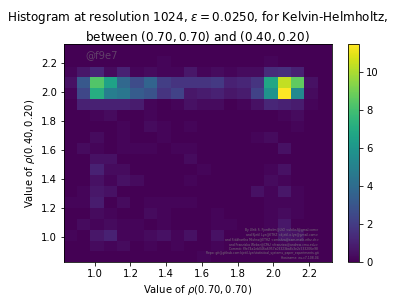

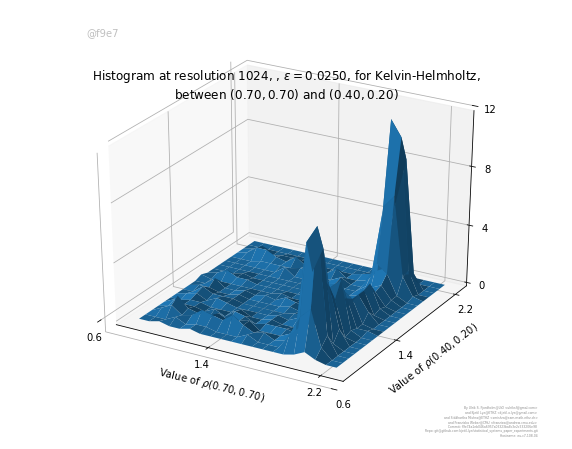

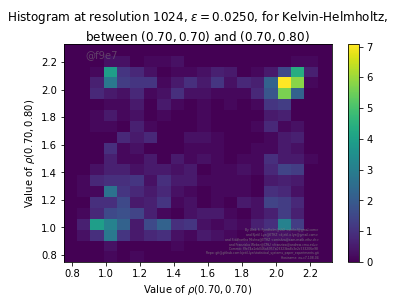

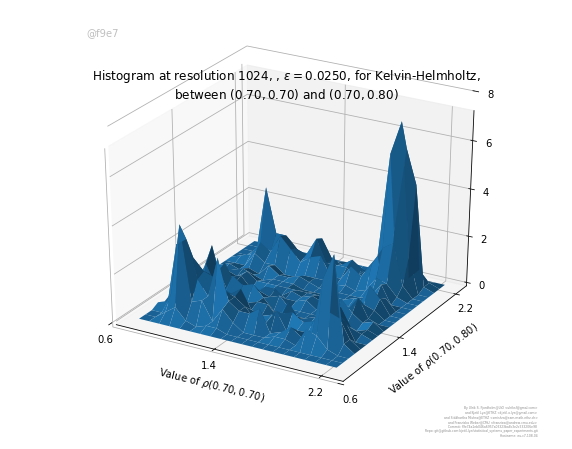

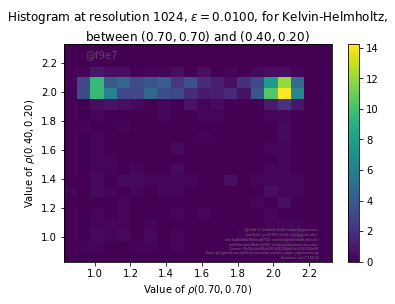

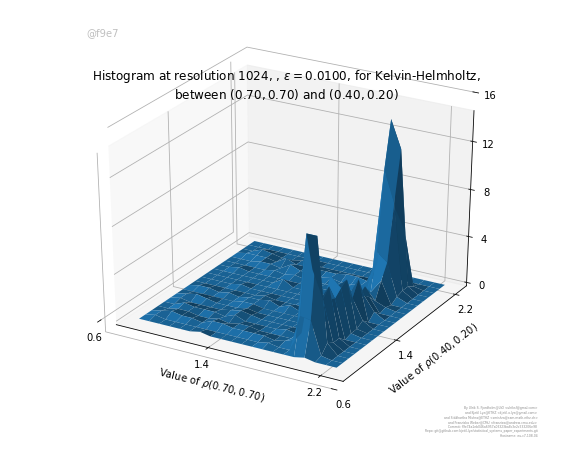

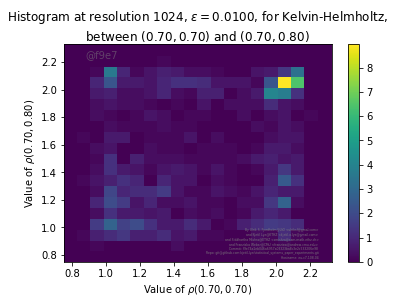

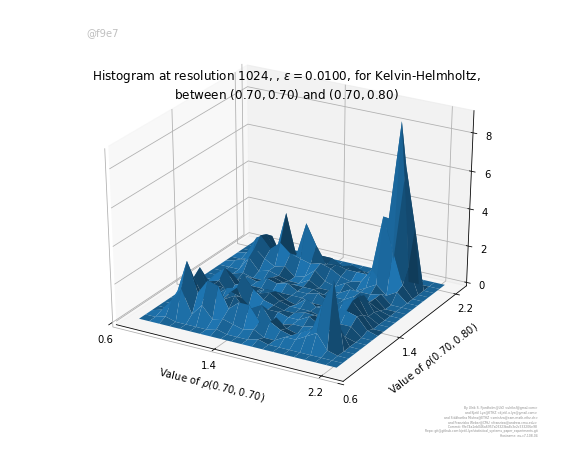

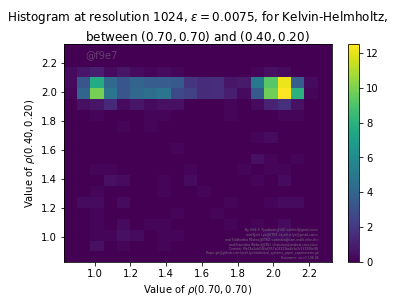

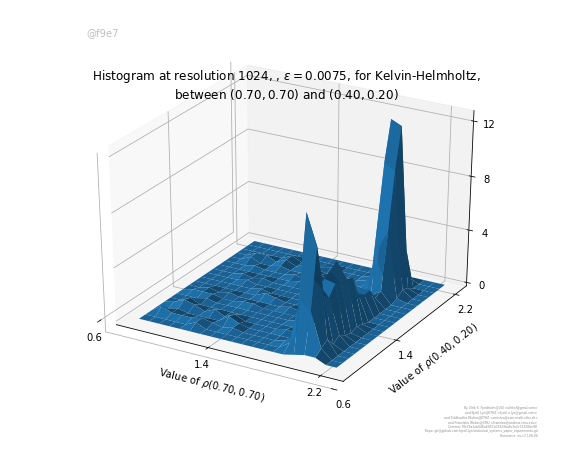

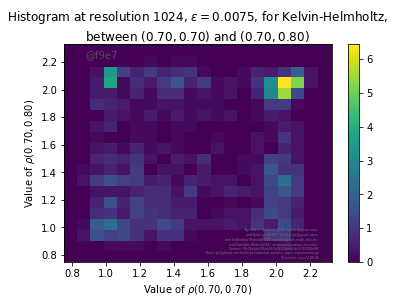

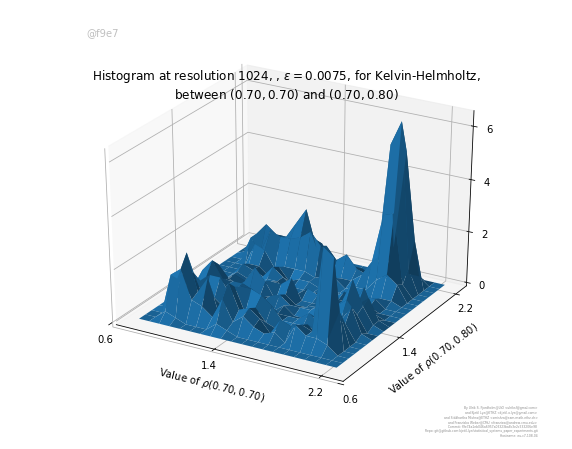

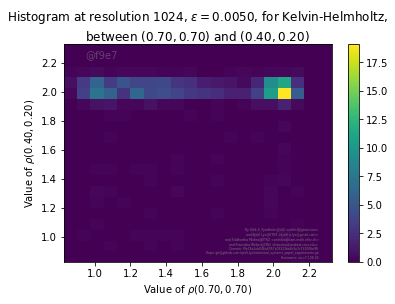

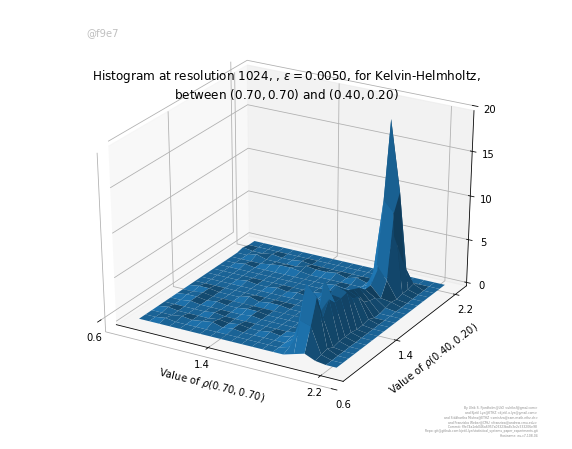

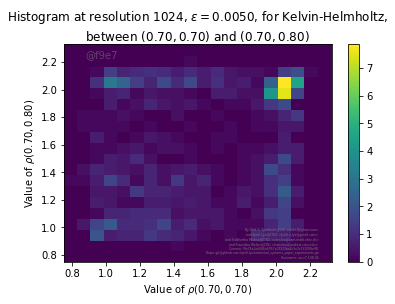

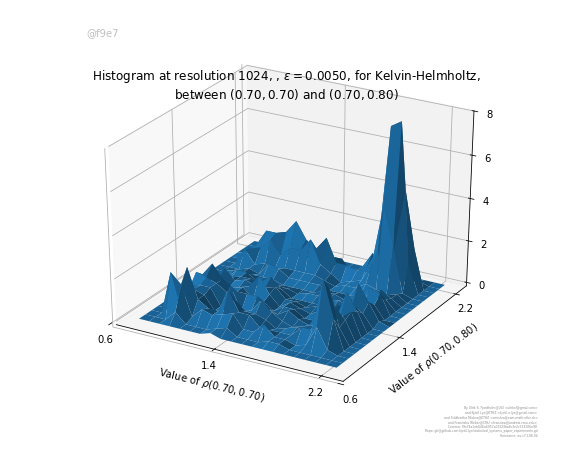

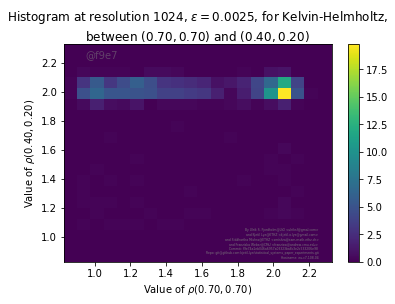

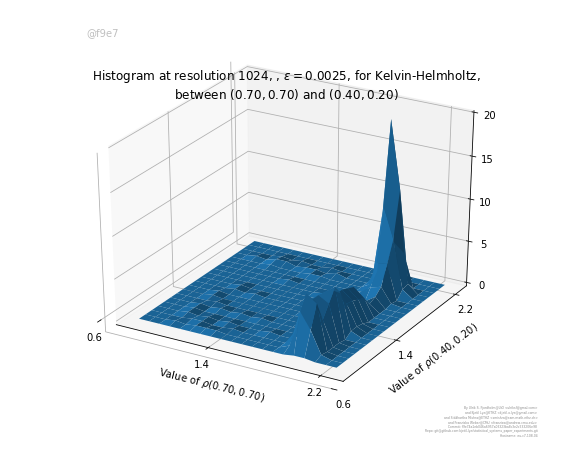

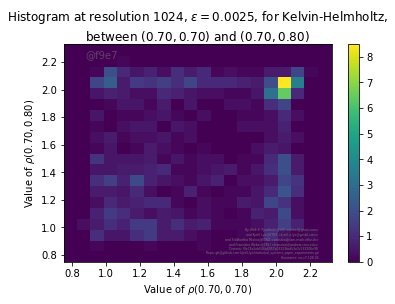

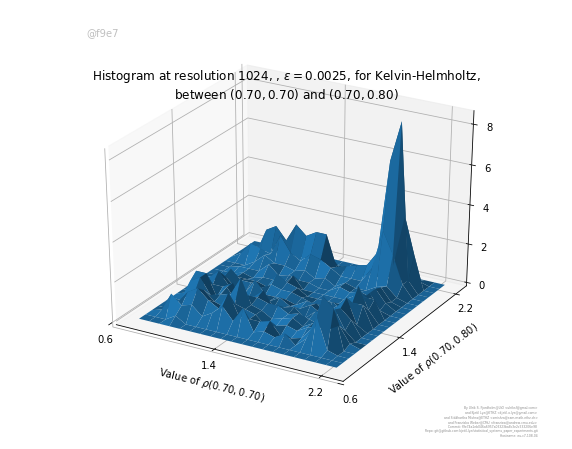

In [5]:

resolution = 1024
perturbations = [0.09, 0.075, 0.06, 0.05, 0.025, 0.01, 0.0075, 0.005,0.0025]

basepath_perts = get_environment("STATISTICAL_KH_PERTS", 
                                 ["kh_perts/q{}/kh_1.nc".format(p) for p in perturbations])

plot_info.console_log("Using basepath_perts={}".format(basepath_perts))


basename = os.path.join(basepath_perts, 'kh_perts/q{perturbation}/kh_1.nc')
name = 'Kelvin-Helmholtz'
samples = 1024

plotWassersteinConvergence(name, basename, resolution, perturbations)
try:
    plotHistograms(name, resolution, perturbations, basename, samples)
except Exception as e:
    plot_info.console_log("Failed making historgrams, \t{}".format(gettatr(e, 'message', repr(e))))


# Convergence for different perturbation types

In this experiment, we have done two perturbations. One with a normal distribution, and one with a uniform distribution. We measure the following for each perturbation size

$$\mathrm{Error}(\epsilon)=\|W_1(\mu^{\epsilon}_{\mathrm{normal}}, \mu^{\epsilon}_{\mathrm{uniform}})\|_{L^1}$$

We plot the error as a function of $\epsilon$. If the statisitical solution is invariant to the different perturbation types, we should get something that converges to zero.

wasserstein2pterrors=[0.13534465733648393]
wasserstein2pterrors=[0.13534465733648393, 0.07457766832828049]
wasserstein2pterrors=[0.13534465733648393, 0.07457766832828049, 0.03452669830011747]
wasserstein2pterrors=[0.13534465733648393, 0.07457766832828049, 0.03452669830011747, 0.01381067932004762]
wasserstein2pterrors=[0.13534465733648393, 0.07457766832828049, 0.03452669830011747, 0.01381067932004762, 0.0027621358640102242]
wasserstein2pterrors=[0.13534465733648393, 0.07457766832828049, 0.03452669830011747, 0.01381067932004762, 0.0027621358640102242, 0.0013810679320051121]
wasserstein2pterrors=[0.13534465733648393, 0.07457766832828049, 0.03452669830011747, 0.01381067932004762, 0.0027621358640102242, 0.0013810679320051121, 0.0013810679320051121]


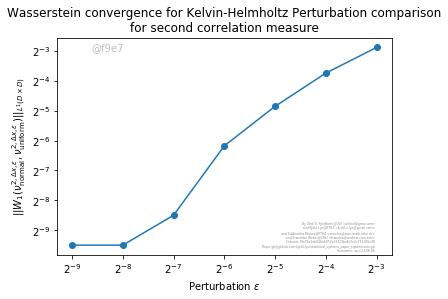

wasserstein1pterrors=[0.095703125]
wasserstein1pterrors=[0.095703125, 0.052734375]
wasserstein1pterrors=[0.095703125, 0.052734375, 0.0244140625]
wasserstein1pterrors=[0.095703125, 0.052734375, 0.0244140625, 0.009765625]
wasserstein1pterrors=[0.095703125, 0.052734375, 0.0244140625, 0.009765625, 0.001953125]
wasserstein1pterrors=[0.095703125, 0.052734375, 0.0244140625, 0.009765625, 0.001953125, 0.0009765625]
wasserstein1pterrors=[0.095703125, 0.052734375, 0.0244140625, 0.009765625, 0.001953125, 0.0009765625, 0.0009765625]


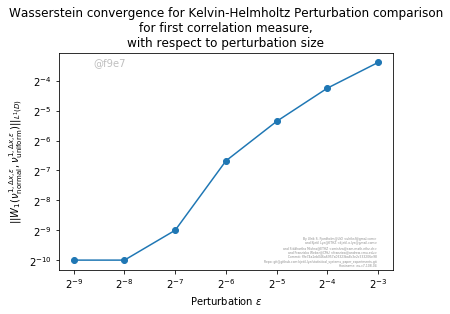

In [6]:

resolution = 1024
pert_inverses = [8, 16, 32, 64, 128, 256, 512]
types = ['normal', 'uniform']

normal_uniform_base = 'dist_{t}/pertinv_{inv}/kh_1.nc'

# all_filenames is just used for verification
all_filenames = []
for t in types:
    for p in pert_inverses:
        all_filenames.append(normal_uniform_base.format(t=t, inv=p))

basepath_perts_normal_uniform = get_environment("STATISTICAL_KH_PERTS_NORMAL_UNIFORM", 
                                 all_filenames)

plot_info.console_log("Using basepath_perts_normal_uniform={}".format(basepath_perts_normal_uniform))


filenames_per_type = {}

for t in types:
    filenames_per_type[t] = []
    for p in pert_inverses:
        filenames_per_type[t].append(os.path.join(basepath_perts_normal_uniform,
                                                  normal_uniform_base.format(t=t,inv=p)))


name = 'Kelvin-Helmholtz Perturbation comparison'
samples = 1024

plotWassersteinConvergenceDifferentTypes(name, filenames_per_type, resolution, pert_inverses)
